In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from train_set import Training_set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [7]:
# X includes the chromosome data
X = Training_set.iloc[:, :-1]
# Y has the last col with labels
y = Training_set.iloc[:, -1]
# Split it to train and test set off validation
Xpca_train, Xpca_test, Ypca_train, Ypca_test = train_test_split(X, y, test_size=0.1, random_state=42)



[0.16352487 0.05221843]


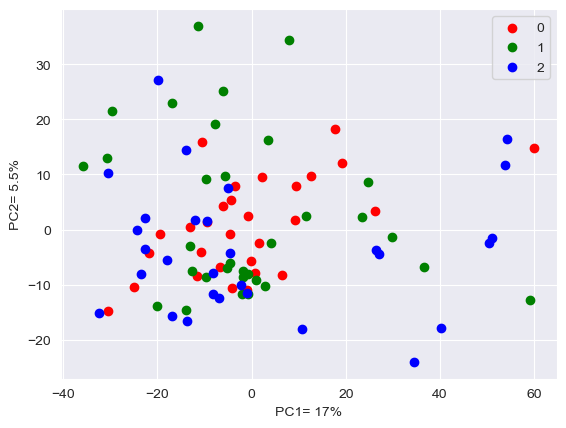

In [8]:
scaler = StandardScaler()
label_encoder = LabelEncoder()
X_scaled = scaler.fit_transform(Xpca_train)
# 2 principle components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# to see how much each pc explains
print(pca.explained_variance_ratio_)

# treate a new DataFrame that includes the PCA results and the labels
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=Xpca_train.index)

# needed to decode the labels for the legend and colors
Y_encoded = label_encoder.fit_transform(Ypca_train)
pca_df['label'] = Y_encoded

# colors for the labels
color_map = {
    0: 'r',  # HER2+
    1: 'g',  # HR+
    2: 'b'  # Triple Neg
}

# scatter plot of the first two PCs
fig, ax = plt.subplots()
for label, color in color_map.items():
    mask = pca_df['label'] == label
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], c=color, label=label)
ax.legend()
ax.set_xlabel('PC1= 17%')
ax.set_ylabel('PC2= 5.5%')
plt.show()
pca_df['label'] = label_encoder.inverse_transform(pca_df['label'])




In [57]:
print(pca_df)

Xpca = pca_df.iloc[:, :-1]
# Y has the last col with labels
Ypca = pca_df.iloc[:, -1]

Xpca.head()

                 PC1        PC2       label
Array.88  -13.633851  11.971359  Triple Neg
Array.47  -17.634836  -7.333074  Triple Neg
Array.110  -0.909466   1.485158       HER2+
Array.56  -31.006856  12.193297         HR+
Array.82   22.954177   0.940647         HR+
...              ...        ...         ...
Array.68   -9.459748   1.027167       HER2+
Array.139   2.151201   9.135081       HER2+
Array.118  26.769885  -4.219546  Triple Neg
Array.30   26.336672  -4.701804  Triple Neg
Array.141  -1.745700  -7.313202         HR+

[80 rows x 3 columns]


,PC1,PC2
Array.88,-13.633851,11.971359
Array.47,-17.634836,-7.333074
Array.110,-0.909466,1.485158
Array.56,-31.006856,12.193297
Array.82,22.954177,0.940647


## Cross validation for parameter tuning

In [74]:
# Define the parameter grid to search over , Here we want to find optimal parameters for our random forest model
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10, 15],
              'min_samples_leaf': [1, 2, 4, 10]
              }
# Define the split for the cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
best_params_list = []
Xfold = Xpca[["PC1", "PC2"]].values

# loop over each fold ( fold= fold counter), train & test indices of the samples in each fold
for fold, (train_index, test_index) in enumerate(skf.split(Xfold, Ypca_train)):
    Xfold_train, Xfold_test = Xfold[train_index], Xfold[test_index]
    Yfold_train, Yfold_test = Ypca_train[train_index], Ypca_train[test_index]

    # parameter tuning for the random forest classifier using GridSearchCV
    rf_model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
    grid_search.fit(Xfold_train, Yfold_train)
    # best hyperparameters from GridSearchCV
    best_params = grid_search.best_params_
    best_params_list.append(grid_search.best_params_)
    # Train the random forest classifier with the best hyperparameters
    clf = RandomForestClassifier(**best_params, random_state=42)
    # Train the classifier on the training data
    clf.fit(Xfold_train, Yfold_train)
    y_pred = clf.predict(Xfold_test)
    score = accuracy_score(Yfold_test, y_pred)
    accuracy_scores.append(score)
    # Print the best hyperparameters
    print("Best hyperparameters: ", grid_search.best_params_)
    print(f'Accuracy: {score:.3f}')

# Calculate the mean accuracy score and its standard deviation
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("Mean accuracy: {:.2f}%".format(mean_accuracy * 100))
print("Standard deviation: {:.2f}%".format(std_accuracy * 100))

Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.375
Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.312
Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.375
Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.625
Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.250
Mean accuracy: 38.75%
Standard deviation: 12.75%


## Median to find the best params out of the loop

In [60]:
avg_best_params = {}
for param_name in param_grid.keys():
    param_values = [params[param_name] for params in best_params_list]
    avg_best_params[param_name] = np.median(param_values)

print("Average best hyperparameters:", avg_best_params)

Average best hyperparameters: {'n_estimators': 100.0, 'max_depth': 5.0, 'min_samples_split': 2.0, 'min_samples_leaf': 4.0}


In [61]:
#train the classifier
clf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)
clf.fit(Xpca_train, Ypca_train)
# evaluate the accuracy of it

Ypca_pred = clf.predict(Xpca_test)
accuracy = accuracy_score(Ypca_test, Ypca_pred)
precision = metrics.precision_score(Ypca_test, Ypca_pred, average='macro')
recall = metrics.recall_score(Ypca_test, Ypca_pred, average='macro')
f1_score = metrics.f1_score(Ypca_test, Ypca_pred, average='macro')
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')

Accuracy: 0.750
Precision: 0.783
Recall: 0.738
F1-score: 0.743


<Axes: >

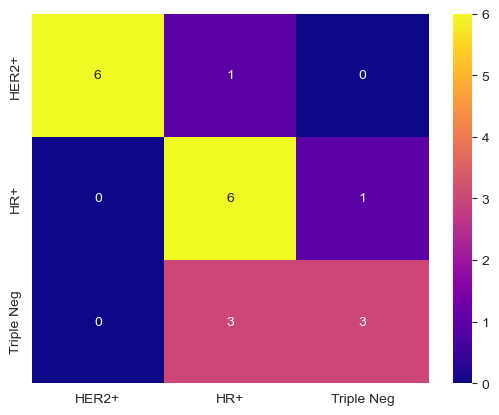

In [62]:
# Confusion matrix
cm = confusion_matrix(Ypca_test, Ypca_pred)
labels = ["HER2+", "HR+", "Triple Neg"]
sns.heatmap(cm, annot=True, cmap="plasma", fmt="d", xticklabels=labels, yticklabels=labels)

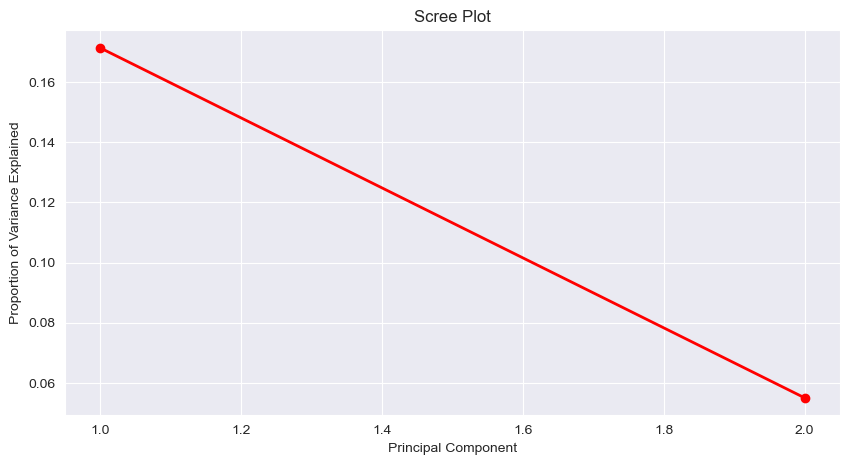

In [63]:
# Calculate the proportion of variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(variance_explained) + 1), variance_explained, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [68]:
# Create a classification report
cr = classification_report(Ypca_test, Ypca_pred)
print(cr)
# Open a text file in write mode
file = open("PCA_report.txt", "w")

# Write to the file
file.write(cr)
# Close the file
file.close()

              precision    recall  f1-score   support

       HER2+       1.00      0.86      0.92         7
         HR+       0.60      0.86      0.71         7
  Triple Neg       0.75      0.50      0.60         6

    accuracy                           0.75        20
   macro avg       0.78      0.74      0.74        20
weighted avg       0.78      0.75      0.75        20

